In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import line_search
plt.rcParams["figure.figsize"] = (20, 10)
EPS = 1e-6
MAX_EPOCH = 100000

def distance(x, y):
    return np.linalg.norm(x - y)

class Function:
    def __init__(self, function, grad, min_point=(0,0)):
        self.call = function
        self.grad = grad
        self.min_point = min_point

    def __call__(self, point):
        return self.call(point)

    def grad(self, point): return self.grad(point)

def make_point(x, y): return np.array((x, y))

def draw_function(f):
    t = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(t, t)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x, y, f((x, y)))

def draw_gradient(f, points):
    colors = ['b', 'g', 'm', 'c', 'orange']
    t = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(t, t)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(f((points[:, 0], points[:, 1])), lw=2, color=colors[0], )
    ax1.grid()
    
    Z = f([X, Y])
    cp = ax2.contourf(X, Y, Z)
    fig.colorbar(cp)
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='r')

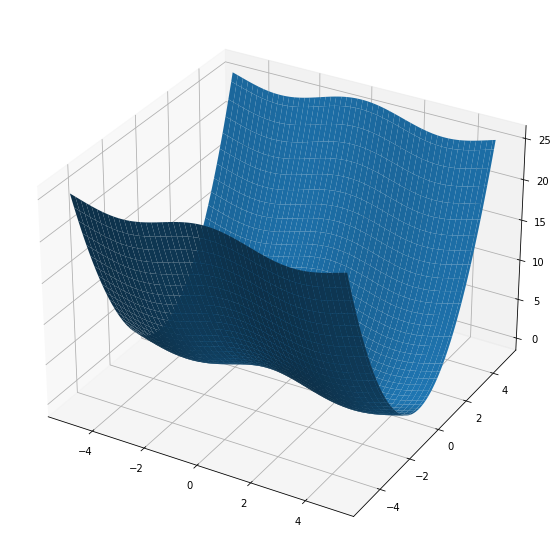

In [10]:
def cosy2(point):
    x, y = point
    return np.cos(x) + y**2

def grad_cosy2(point):
    x, y = point
    return make_point(-np.sin(x), 2*y)

fun = Function(cosy2, grad_cosy2, np.array((math.pi, 0)))
draw_function(fun)

__Задание 1__

In [11]:
def abstract_gradient_descent(first_point, next_point_fun, stop_criteria):
    points = np.array([first_point])
    x = first_point
    epoch = 0
    while not stop_criteria(x) and epoch < MAX_EPOCH:
        x = next_point_fun(x, epoch)
        points = np.append(points, [x], axis=0)
        epoch += 1
    return points

def stop_by_grad(f):
    return lambda x: np.linalg.norm(f.grad(x)) < EPS

def lin_rate_grad_descent(f, first_point, lin_rate):
    next_point = lambda x, epoch: x - lin_rate(epoch) * np.array(f.grad(x))
    return abstract_gradient_descent(first_point, next_point, stop_by_grad(f))

Посмотрим, за сколько шагов наш градиентный спуск приходит к минимуму в зависимости от параметра linear_rate

In [12]:
def test(f, first_point, grad_descent, test_list):
    def run(lr):
        return grad_descent(f, first_point, lambda _: lr)
    ans = pd.DataFrame()
    ans["Linear rate"] = test_list
    ans["Epochs"] = list(map(lambda a: a.size, map(run, test_list)))
    return ans

lin_rate_test_list = list(i for i in np.arange(0.4, 0.8, 0.02))
test(fun, make_point(2, 1), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.40,58
1,0.42,56
2,0.44,52
3,0.46,50
4,0.48,46
5,0.50,44
6,0.52,42
7,0.54,40
8,0.56,38
9,0.58,36


__Задание 2__

In [13]:
def exp_lin_rate_grad_descent(f, first_point, d):
    return lin_rate_grad_descent(f, first_point, lambda epoch: np.exp(-d * epoch))

def test(f, first_point, test_list):
    def run(d):
        return exp_lin_rate_grad_descent(f, first_point, d)
    ans = pd.DataFrame()
    ans["d"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans

exp_lin_rate_test_list = list(i for i in np.arange(0.05, 0.10, 0.005))
test(fun, make_point(2, 1), exp_lin_rate_test_list)

,d,Epochs
0,0.050,15
1,0.055,15
2,0.060,14
3,0.065,13
4,0.070,12
5,0.075,12
6,0.080,13
7,0.085,14
8,0.090,15
9,0.095,17


__Задание 3__
Улучшим наш градиентный спуск с помощью дихотомии:

12

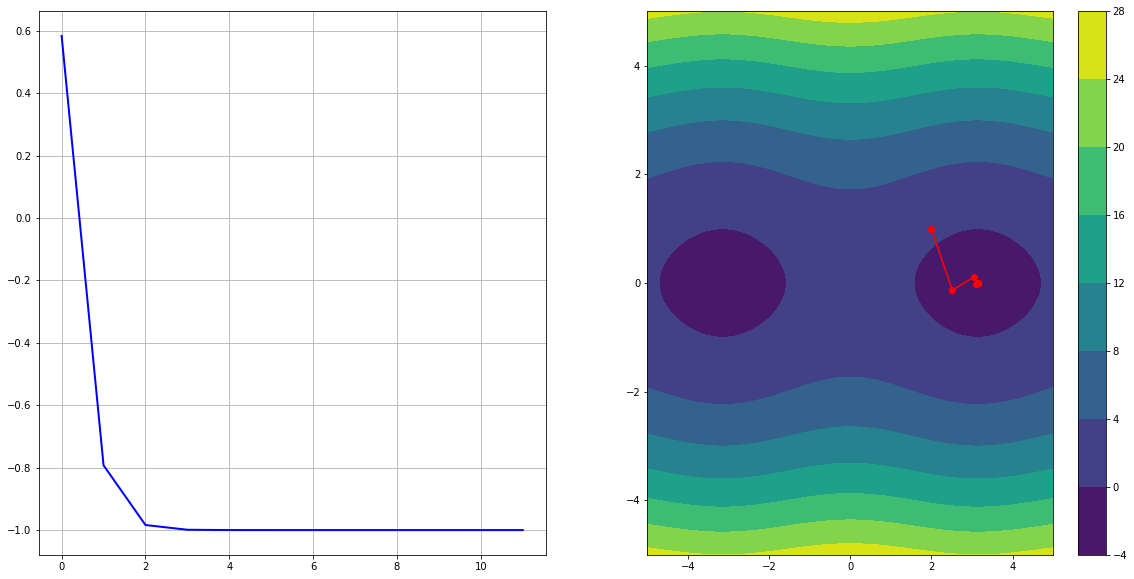

In [14]:
def dichotomy_grad_descent_constructor(left_bound, right_bound, delta):
    def dichotomy(f):
        left = left_bound
        right = right_bound
        x = left
        while right - left >= EPS:
            x = (left + right) / 2
            if f(x - delta) <= f(x + delta):
                right = x
            else:
                left = x
        return x

    def impl(f, first_point):
        def next_point_fun(x, epoch):
            d = dichotomy(lambda a: f(x - a * f.grad(x)))
            return x - d * f.grad(x)
        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))
    return impl

dichotomy_grad_descent = dichotomy_grad_descent_constructor(-1, 1, 0.02)
ps = dichotomy_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

__Задание 4__
Применим к полученному алгоритму усиленные условия Вольфе  
  
![alt text](Wolphe.png)    
  
Первое неравенство отвечает за уменьшение функции после совершения шага, второе неравенство -- за уменьшение проекции градиента по модулю, чтобы не допустить точек далеких от стационарных  
Как правило : $c_1 = 0.0001$, $c_2 = 0.9$


12

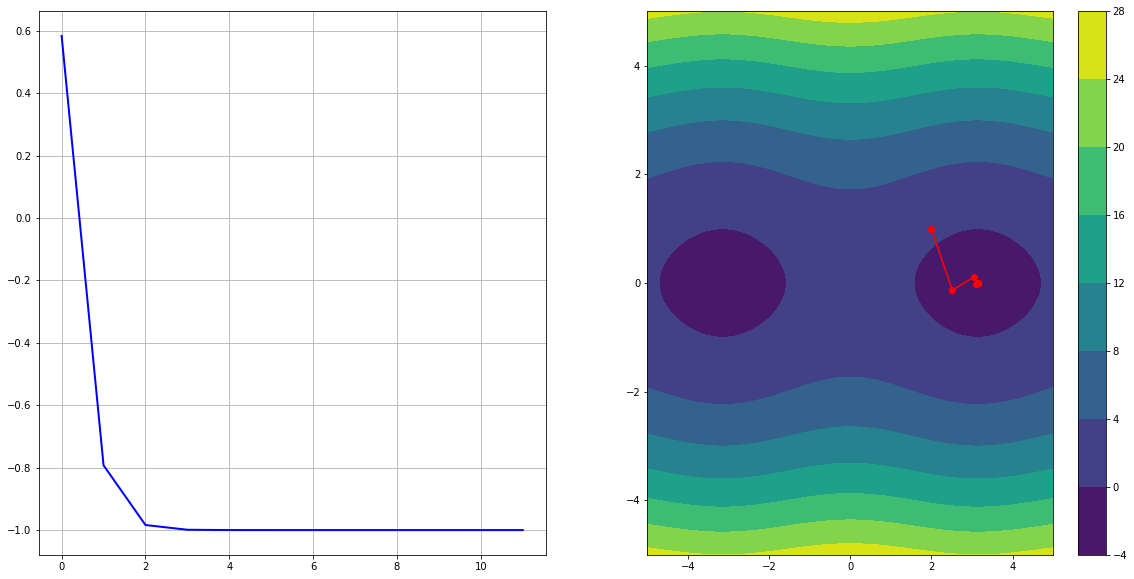

In [15]:
def dichotomy_grad_descent_constructor(left_bound, right_bound, delta):
    def first_Wolphe_condition(alpha, x):
        return np.all(fun(x - alpha*fun.grad(x)) <= fun(x) - C1 * alpha* fun.grad(x)**2)
    def second_Wolphe_condition(alpha, x):
        return np.all(abs(fun.grad(x - alpha * fun.grad(x)) * fun.grad(x)) <= C2 * abs(fun.grad(x)))
    def Wolphe_conditions(alpha, x):
        eps = 0
        global C1
        C1 = 1e-4
        global C2
        C2 = 0.9
        for i in range(MAX_EPOCH):
            alpha_right = alpha + eps
            alpha_left = alpha - eps
            if not (second_Wolphe_condition(alpha_right, x) and first_Wolphe_condition(alpha_right, x)):
                if not (second_Wolphe_condition(alpha_left, x) and first_Wolphe_condition(alpha_left, x)):
                    eps = eps + 0.001 if eps == 0 else eps * 2
                else:
                    return alpha_left
            else:
                return alpha_right            
            
    def dichotomy_with_Wolphe(f, cur_point):
        left = left_bound
        right = right_bound
        alpha = left
        while right - left >= EPS:
            alpha = (left + right) / 2
            if f(alpha - delta) <= f(alpha + delta):
                right = alpha
            else:
                left = alpha

        return Wolphe_conditions(alpha, cur_point)

    def impl(f, first_point):
        def next_point_fun(x, epoch):
            d = dichotomy_with_Wolphe(lambda a: f(x - a * f.grad(x)), x)
            return x - d * f.grad(x)
        return abstract_gradient_descent(first_point, next_point_fun, stop_by_grad(f))
    return impl

dichotomy_grad_descent = dichotomy_grad_descent_constructor(-1, 1, 0.02)
ps = dichotomy_grad_descent(fun, make_point(2, 1))
draw_gradient(fun, ps)
len(ps)

__Задание 5__

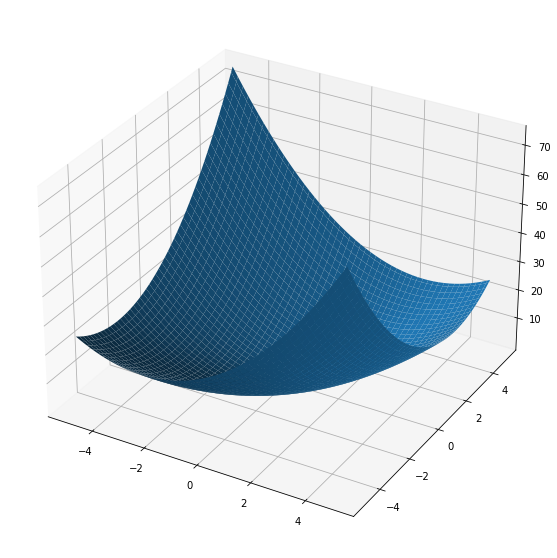

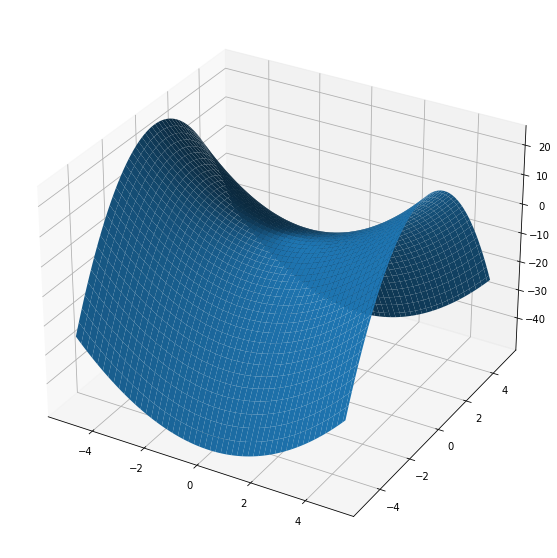

In [16]:
def func1(point):
    x, y = point
    return x**2 + y**2 - x * y

def grad1(point):
    x, y = point
    return make_point(2*x - y, 2*y - x)

fun1 = Function(func1, grad1, np.array((0, 0)))
draw_function(fun1)

def func2(point):
    x, y = point
    return x**2 - 2 * y**2

def grad2(point):
    x, y = point
    return make_point(2*x, -4*y)

fun2 = Function(func2, grad2, np.array((0, 0)))
draw_function(fun2)

11

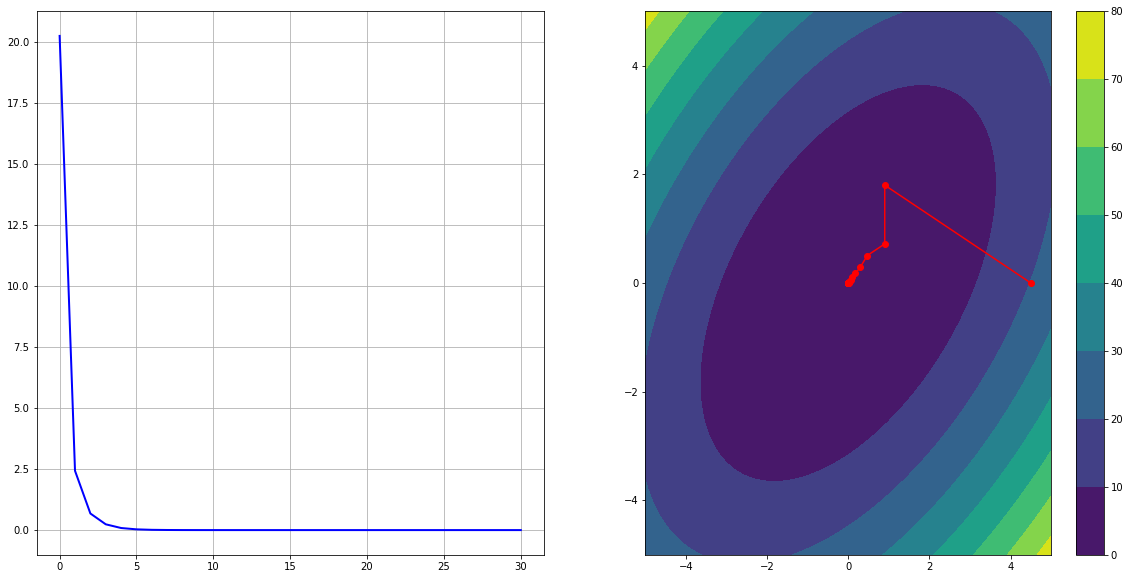

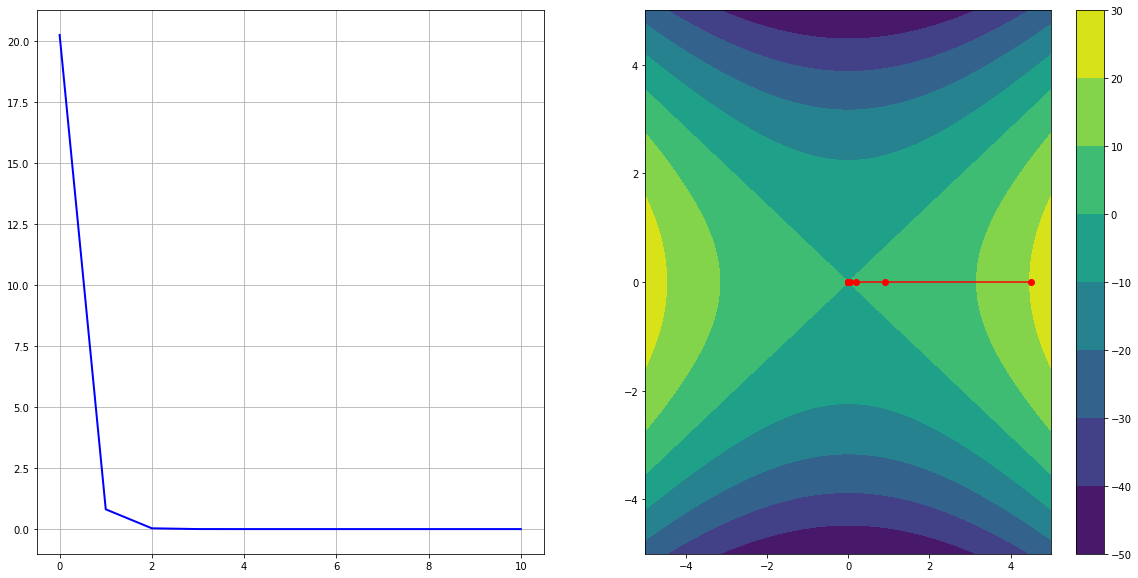

In [17]:
points_grad1 = lin_rate_grad_descent(fun1, make_point(4.5, 0), lambda _: 0.4)
points_grad2 = lin_rate_grad_descent(fun2, make_point(4.5, 0), lambda _: 0.4)
draw_gradient(fun1, points_grad1)
draw_gradient(fun2, points_grad2)

len(points_grad1)
len(points_grad2)